# Question 1 MSF 1

In [1]:
from numpy import log, sqrt, exp, linspace, pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy import stats

### On travaille dans le cadre du modèle de Black & Scholes. Dans toutes ces questions, on considère un call européen de maturité T et de strike K. On pourra prendre comme valeurs de référence : $S_0 = 100, K = 100, T = 1, r = 0.05, σ = 0.20$.

### 1 - Pour différentes valeurs de $T$, tracer sur un même graphe en fonction de $S_0$ le prix du call européen de maturité $T$ obtenu par la formule de Black & Scholes. Commenter. Même question pour le $\Delta$ et le $\Gamma$ du call.

On rappelle la formule du prix d'un call européen :

$$C = S_0 N(d1) - e^{-rT} K N(d2)$$

avec N(x) donnée par :
    
   $$ N(x) = \frac{1}{sqrt(2*\pi)} \int^x_{-\infty} e^{-\frac{1}{2}s^2} ds $$

In [2]:
def norm_pdf(x):
    """
    Fonction densité pour la loi normale standard
    """
    
    return (1.0 / ((2 * np.pi) ** 0.5)) * np.exp(-0.5 * (x ** 2))

def norm_cdf(x):
    """
    Approximation de la fonction de répartition de la loi normale
    centrée réduite

    Référence :
    26.2.17 page 932 de abramowitz_and_stegun.pdf textbook on mathematical functions
    
    On utilisera sûrement par la suite le module statistics de python pour obtenir
    les mêmes résultats en moins de temps.
    """
    
    k = 1.0 / (1.0 + 0.2316419 * x)
    k_sum = k * (0.319381530 + k * (- 0.356563782 + \
        k * (1.781477937 + k * (- 1.821255978 + 1.330274429 * k))))

    if x >= 0.0:
        return (1.0 - (1.0 / ((2 * pi) ** 0.5)) * np.exp(- 0.5 * x ** 2) * k_sum)
    else:
        return 1.0 - norm_cdf(- x)

def price_european_call(S_0, K, T, r, sigma):
    """
    Prix du call européen avec Black-Scholes
    """
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    return S_0 * norm_cdf(d1) - np.exp(- r * T) * K * norm_cdf(d2)


def delta_european_call(S_0, K, T, r, sigma):
    """
    Delta : Sensibilité du prix d'un call par rapport aux sous-jacents
    Dérivée du premier ordre
    """
    
    if T == 0:
        return 1.0 if S_0 > K else 0.0
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    
    return norm_cdf(d1)

def gamma_european_call(S_0, K, T, r, sigma):
    """
    Gamma : Sensibilité d'une "accélération" du prix du call
    par un mouvement de sous-jacent
    Dérivée du deuxième ordre
    """
    if T == 0:
        return 0.0
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    return norm_pdf(d1) / (S_0 * sigma * np.sqrt(T))

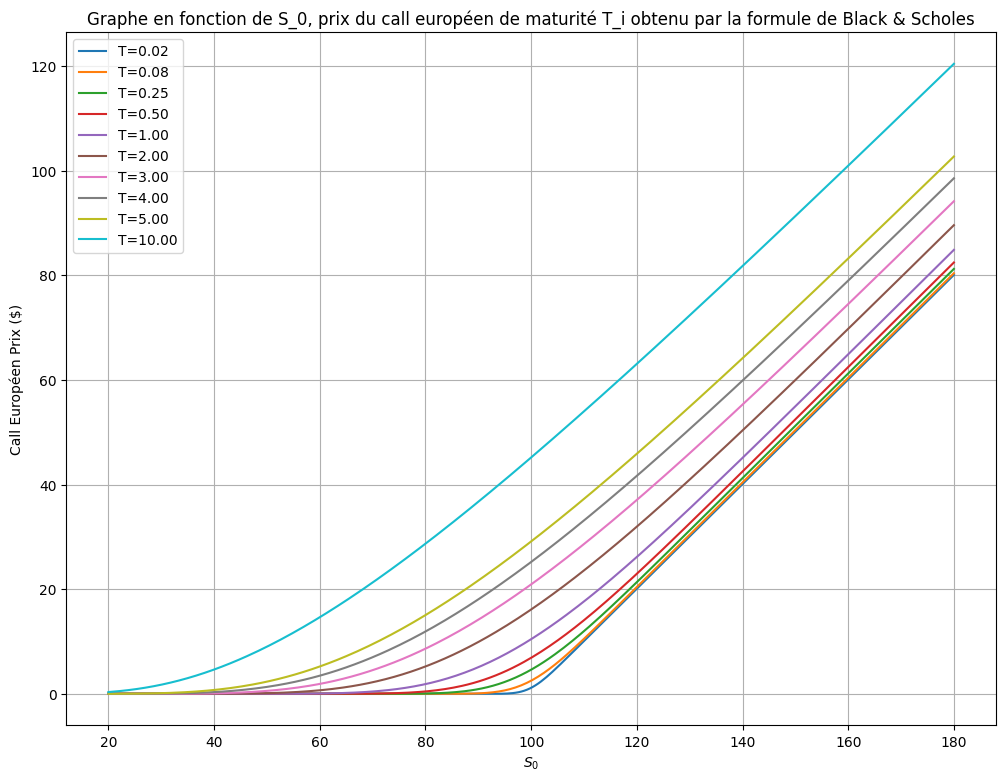

In [3]:
# Parameters
S0_values = np.linspace(20, 180, 300) 
# 300 points nécessaire pour smoothness de gamma (dirac)
K = 100
T_list = [7 / 365, 1 / 12, 1 / 4, 1 / 2, 1, 2, 3, 4, 5, 10] # d'une semaine à 10 ans
r = 0.05
sigma = 0.2

plt.figure(figsize=(12, 9))

for T in T_list:
    call_prix = [price_european_call(S0, K, T, r, sigma) for S0 in S0_values]
    plt.plot(S0_values, call_prix, label=f'T={T:.2f}')
    
plt.xlabel('$S_0$')
plt.ylabel('Call Européen Prix ($)')
plt.title('Graphe en fonction de S_0, prix du call \
européen de maturité T_i obtenu par la formule de Black & Scholes')
plt.legend()
plt.grid()
plt.show()

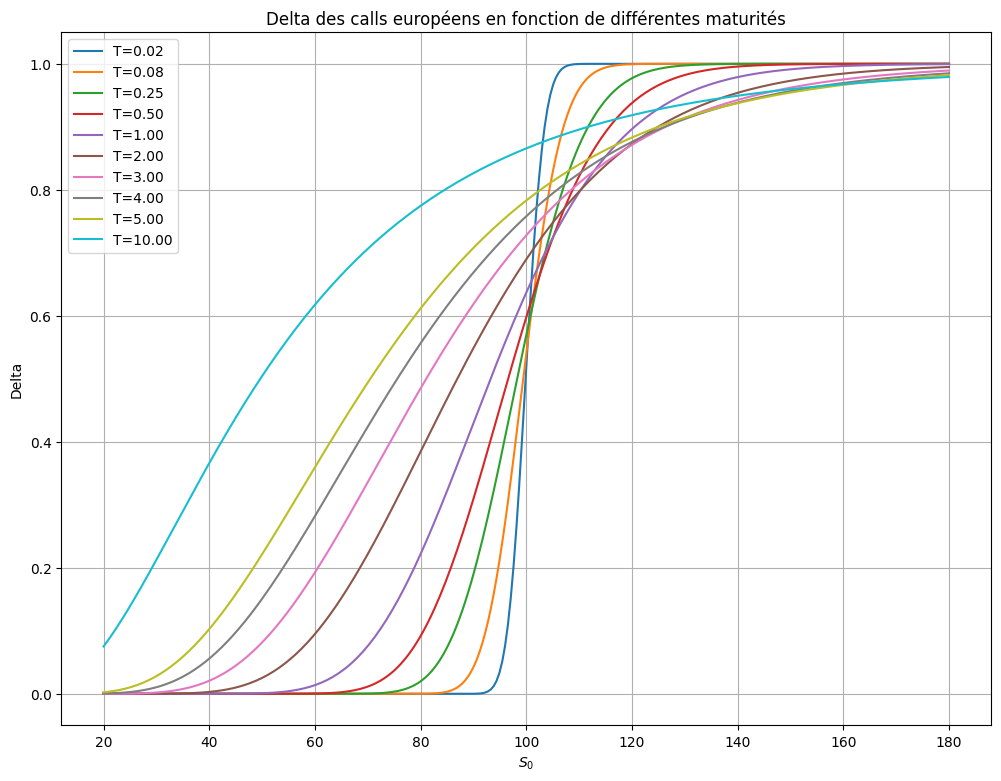

In [4]:
plt.figure(figsize=(12, 9))

for T in T_list:
    deltas = [delta_european_call(S0, K, T, r, sigma) for S0 in S0_values]
    plt.plot(S0_values, deltas, label=f'T={T:.2f}')
    
plt.xlabel('$S_0$')
plt.ylabel('Delta')
plt.title('Delta des calls européens en fonction de différentes maturités')
plt.legend()
plt.grid()
plt.show()

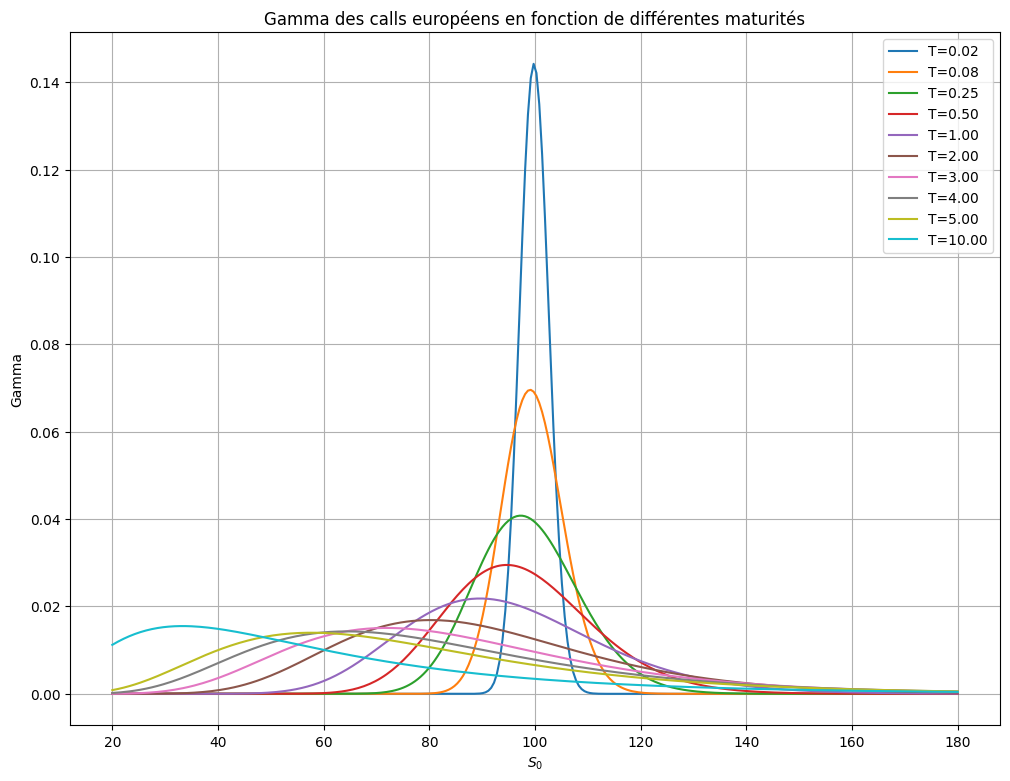

In [5]:
plt.figure(figsize=(12, 9))

for T in T_list:
    gammas = [gamma_european_call(S0, K, T, r, sigma) for S0 in S0_values]
    plt.plot(S0_values, gammas, label=f'T={T:.2f}')
    
plt.xlabel('$S_0$')
plt.ylabel('Gamma')
plt.title('Gamma des calls européens en fonction de différentes maturités')
plt.legend()
plt.grid()
plt.show()

Il y a plusieurs remarques à faire sur les graphes :

- Plus la maturité est grande, plus le sous-jacent a de probabilité d'être dans la monnaie, même au départ out of money.

- Plus la maturité est grande, plus le delta ATM sur un call européen est élevée car il faut prendre en compte la valeur temps (0.5 pour une option 1 jour à environ 0.65 pour une option 1 an).

- Plus la maturité est grande, plus la courbe du dirac tend vers l'ATM pour les mêmes raisons que le delta 

### 2. Tracer en fonction de N (nombre de simulations) le prix Monte Carlo et l’intervalle de confiance associé (échelle logarithmique sur l’axe des abscisses). Commenter. A partir de quel N obtient-on une erreur relative du prix Monte Carlo inférieure à $0.1\%$ ?

Une autre méthode pour calculer le prix d'une option d'achat consiste à utiliser les méthodes de Monte Carlo. Le point de départ est de considérer l'équation du mouvement brownien pour l'action sous-jacente $S(t)$ :  

$$
dS = S\,r dt +S\sigma dz\,
$$

où nous avons posé $\mu = r$, car nous travaillons dans un cadre sans risque. Cette équation peut être discrétisée à l'aide d'un schéma d'Euler. En procédant ainsi, on obtient le niveau de l'indice $S_{T}$ à une date future $T$, étant donné un niveau $S_{t}$, sous la forme :  

$$
S_{T} = S_{t}\exp\left(\left(r-\frac{1}{2}\sigma^{2}\right)(T-t) +\sigma \sqrt{T-t}\,z\right)\,
$$

où $z$ est une variable aléatoire suivant une distribution normale.  

Nous savons que, dans le cas d'une option d'achat, la fonction de payoff à l'échéance $T$ est donnée par :  

$$
h(S_{T}) = \max \left( S_{T}-X,0\right)\,
$$

Ensuite, dans le cas particulier d'un cadre sans risque, il peut être démontré que le prix de l'option d'achat est donné par :  

$$
C(T)  = e^{-r(T-t)}\int_{-\infty}^{\infty}dS_{T}\,h(S_{T})\,q(S_{T})\,
$$

où $q(S)$ est une densité de probabilité pour le processus équivalent de martingale associé à $S_{t}$. Cette intégrale peut en fait être discrétisée, ce qui donne :  

$$
C(T) = e^{-r(T-t)}\frac{1}{I}\sum_{i = 1}^{I}h(S_{T}^{i})\,
$$

où la somme est effectuée sur une collection de valeurs $S_{T}^{i}$ suivant un mouvement brownien géométrique, qui peut être générée par simulation de Monte Carlo.


In [6]:
def BS_Call_MC(S, X, r, sigma, T, t, N, seed=None):
    """
    Calcule le prix d'un call européen via Monte Carlo 
    (Black–Scholes) en une seule étape :
      - S : spot initial (à t)
      - X : strike
      - r : taux sans risque
      - sigma : volatilité
      - T : maturité finale
      - t : temps courant (souvent t=0)
      - N : nombre de simulations
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Tirage de N gaussiennes standard
    z = np.random.normal(0, 1, N)

    # Formule de Black–Scholes pour passer de S_t à S_T en "une étape" avec un mouvement brownien géométrique
    ST = S * np.exp((r - 0.5 * sigma**2) * (T - t) + sigma * sqrt(T - t) * z)

    # Payoff (non actualisé)
    payoff = np.maximum(ST - X, 0)
    
    # Payoff actualisé
    payoff_discounted = np.exp(-r * (T - t)) * payoff
    
    # Prix Monte Carlo = moyenne du payoff actualisé
    MC_call_price = np.mean(payoff_discounted)
    
    # Écart-type empirique du payoff actualisé
    # => on utilise payoff_discounted et NON payoff seul pour se ramener dans la mesure Q.
    std_payoff = np.std(payoff_discounted, ddof=1)

    return MC_call_price, std_payoff

In [7]:
S0 = 100
K   = 100
r   = 0.05
sigma = 0.2
T   = 1.0
t   = 0.0

N_list = [100, 500, 1_000, 5_000, 9_000, 9_800, 10_000, 20_000, 50_000, 100_000, 500_000, 1_000_0000]
mc_prices, conf_intervals = [], []

for N in N_list:
    price_MC, std_payoff = BS_Call_MC(S0, K, r, sigma, T, t, N)
    mc_prices.append(price_MC)

    # Intervalle de confiance à 95%
    conf_margin = 1.96 * (std_payoff / np.sqrt(N))
    conf_intervals.append(conf_margin)

# Calcul de la borne inférieure pour l'erreur relative de 0,1%
true_price = mc_prices[-1]  # On suppose que le prix avec le plus grand N est la valeur de référence
errors = [abs((price - true_price) / true_price) for price in mc_prices]
N_threshold = next((N for N, err in zip(N_list, errors) if err < 0.001), None)

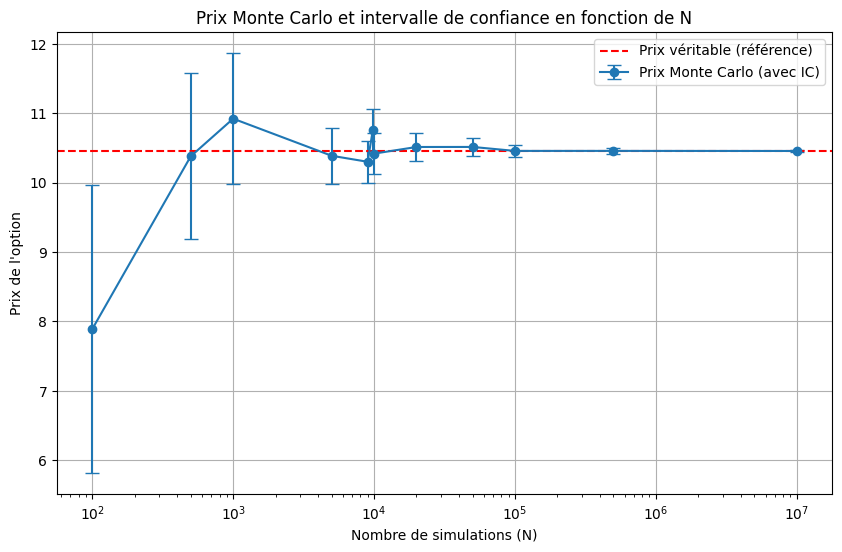

Nombre minimal de simulations pour une erreur relative < 0,1% : 100000


In [8]:
# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.errorbar(N_list, mc_prices, yerr=conf_intervals, fmt='o-', label='Prix Monte Carlo (avec IC)', capsize=5)
plt.axhline(y=true_price, color='r', linestyle='--', label='Prix véritable (référence)')
plt.xscale('log')
plt.xlabel('Nombre de simulations (N)')
plt.ylabel("Prix de l'option")  # Use double quotes around the string
plt.title('Prix Monte Carlo et intervalle de confiance en fonction de N')
plt.legend()
plt.grid(True)
plt.show()

# Afficher à partir de quel N l'erreur relative est < 0.1%
print(f"Nombre minimal de simulations pour une erreur relative < 0,1% : {N_threshold}")

À mesure que le nombre de variables aléatoires augmente, le prix calculé converge vers celui obtenu par la formule de Black-Scholes. Ce comportement est conforme à la loi des grands nombres, qui affirme que la moyenne des résultats issus d’un grand nombre de tirages indépendants tend à se rapprocher de l’espérance. Dès que 
$N≈9800$ (en fonction de la compilation), on observe une forte convergence vers le prix du call européen de la formule fermée avec une erreur inférieure à 0.1%.

### 3. Pour un N fixé, simuler 100 prix de Monte Carlo et calculer l’écart-type  $\hat{\sigma}$ de ces prix. Faites varier N et tracer $\hat{\sigma}$ en fonction de N en échelle logarithmique. Commenter.

Nous faisons varier le nombre de simulations Monte Carlo, $N$, pour estimer un call européen selon le modèle de Black-Scholes.
Pour chaque $N$, nous exécutons 100 simulations indépendantes et calculons l'écart-type des prix Monte Carlo ($\hat{\sigma}$).

In [9]:
# Nombre de simulations fixé
N_fixed = 10_000

# Simuler 100 prix Monte Carlo pour un N fixé
n_simulations = 100
mc_prices = []

for i in range(n_simulations):
    price_MC, _ = BS_Call_MC(S0, K, r, sigma, T, t, N_fixed, seed=i)
    mc_prices.append(price_MC)

# Calcul de l'écart-type des prix Monte Carlo
sigma_hat = np.std(mc_prices, ddof=1)

print(f"Écart-type des 100 prix Monte Carlo (σ̂) : {sigma_hat}")

Écart-type des 100 prix Monte Carlo (σ̂) : 0.16157797173349572


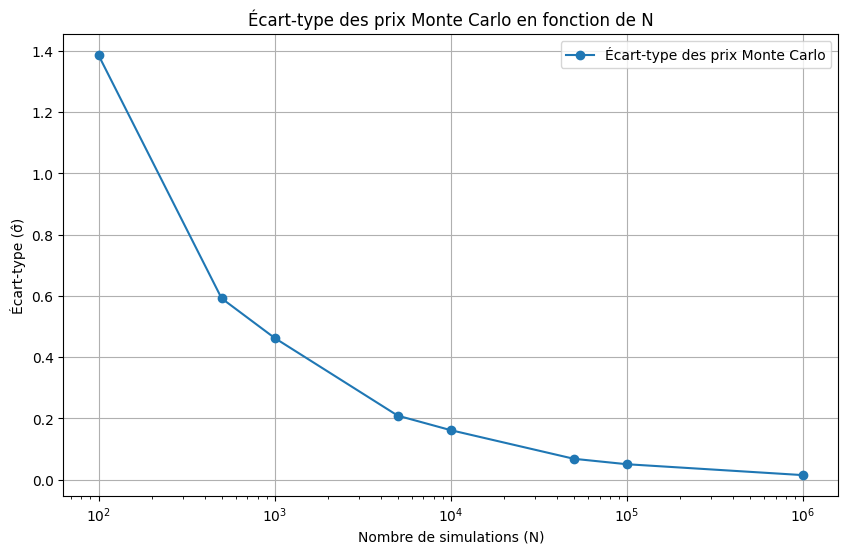

In [10]:
# En faisant varier N et pour calculer sigma estimé
N_list_values = [100, 500, 1_000, 5_000, 10_000, 50_000, 100_000, 1_000_000]
sigma_hats = []

for N in N_list_values:
    mc_prices = []
    for i in range(100):  # Simuler 100 prix Monte Carlo pour chaque N
        price_MC, _ = BS_Call_MC(S0, K, r, sigma, T, t, N, seed=i) 
        # avec un random différent pour vérifier l'indépendance
        mc_prices.append(price_MC)
    sigma_hat = np.std(mc_prices, ddof=1)  # Calcul de l'écart-type
    sigma_hats.append(sigma_hat)

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(N_list_values, sigma_hats, marker='o', linestyle='-', label='Écart-type des prix Monte Carlo')
plt.xscale('log')
plt.xlabel('Nombre de simulations (N)')
plt.ylabel('Écart-type (σ̂)')
plt.title('Écart-type des prix Monte Carlo en fonction de N')
plt.grid(True)
plt.legend()
plt.show()

Les résultats sont tracés en échelle logarithmique comme pour la question 2, il est clair qu'il y a dépendance de $\hat{\sigma}$ en fonction de $N$ et que $\hat{\sigma}$ diminue avec l'augmentation de $N$ selon la loi des grands nombres.

### 4. Pour un N fixé, simuler 1 000 prix de Monte Carlo. Tracer leur densité empirique et répéter pour différentes valeurs de N. Commenter.

In [11]:
# Simuler 1 000 prix Monte Carlo pour un N fixé
N_fixed = 10_000
mc_prices = []

for i in range(1_000):
    price_MC, _ = BS_Call_MC(S0, K, r, sigma, T, t, N_fixed, seed=i)
    mc_prices.append(price_MC)

# Calcul de la densité empirique
kde = gaussian_kde(mc_prices)
x_range = np.linspace(min(mc_prices), max(mc_prices), 1000)
density = kde(x_range)

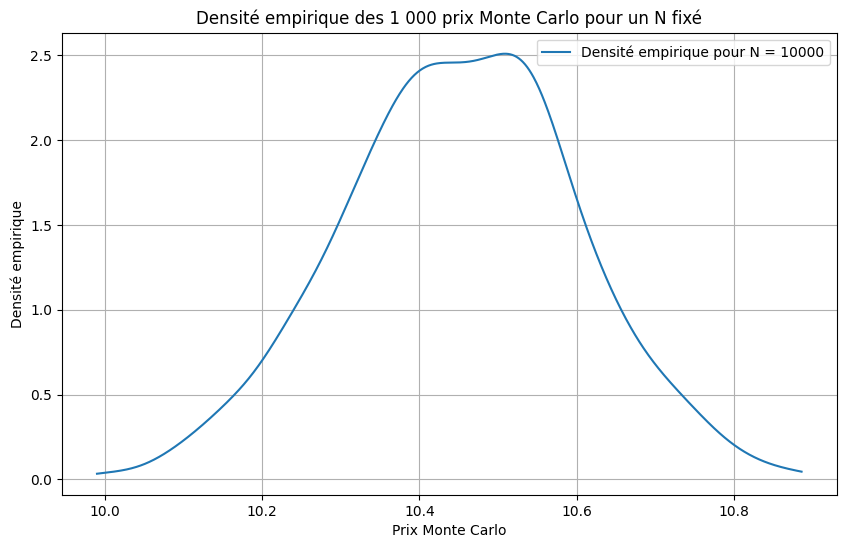

In [12]:
# Tracer la densité empirique
plt.figure(figsize=(10, 6))
plt.plot(x_range, density, label=f'Densité empirique pour N = {N_fixed}')
plt.xlabel('Prix Monte Carlo')
plt.ylabel('Densité empirique')
plt.title('Densité empirique des 1 000 prix Monte Carlo pour un N fixé')
plt.legend()
plt.grid(True)
plt.show()

Plus le nombre de prix Monte Carlo est simulé plus il converge vers une gaussienne par la loi forte des grand nombres.

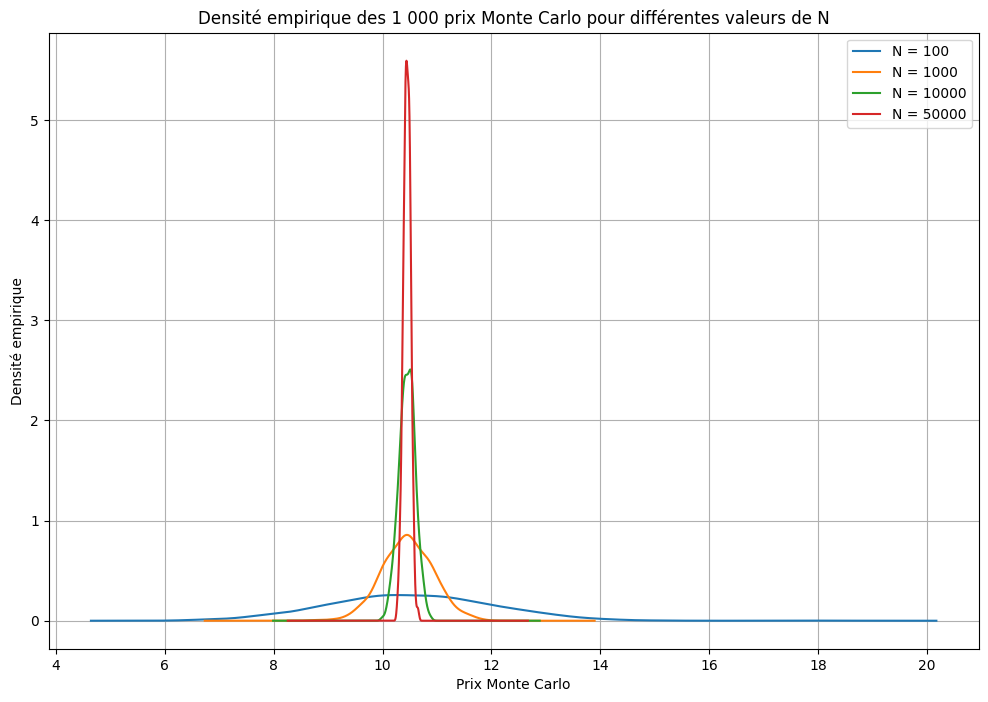

In [13]:
N_values = [100, 1_000, 10_000, 50_000]
plt.figure(figsize=(12, 8))

for N_fixed in N_values:
    mc_prices = []
    for i in range(1_000):  # Simuler 1 000 prix Monte Carlo pour chaque N
        price_MC, _ = BS_Call_MC(S0, K, r, sigma, T, t, N_fixed, seed=i)
        mc_prices.append(price_MC)

    # Calcul de la densité empirique
    kde = gaussian_kde(mc_prices)
    margin = 2
    x_range = np.linspace(min(mc_prices) - margin, max(mc_prices) + margin, 5000)
    density = kde(x_range)
    plt.plot(x_range, density, label=f'N = {N_fixed}')

plt.xlabel('Prix Monte Carlo')
plt.ylabel('Densité empirique')
plt.title('Densité empirique des 1 000 prix Monte Carlo pour différentes valeurs de N')
plt.legend()
plt.grid(True)
plt.show()

Plus le nombre de trajectoires est élevé plus la densité empirique tend vers un dirac qui a une unique valeur celle de la formule Black-Scholes fermée.

L'erreur décroit en fonction de N avec une vitesse en $\frac{1}{\sqrt(N)}$, montrant la vitesse de convergence de l'estimateur de Monte Carlo en $\frac{1}{\sqrt(N)}$

### 5. En utilisant %%timeit en début de cellule, mesurer le temps de calcul moyen d’un prix Monte Carlo à $N = 10^6$ simulations avec votre code.

In [14]:
# Mesurer le temps de calcul moyen pour N = 10^6
N_question5 = 1_000_000

In [15]:
%%timeit -n 100 -r 10
BS_Call_MC(S0, K, r, sigma, T, t, N_question5)

51.5 ms ± 2.63 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)
